In [1]:
import os
import fnmatch
import pprint
import csv
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.linalg import sqrtm
from analysis_clustering_helpers import get_cvfold_crossmodal_recon

cvsets_pth   = './data/results/patchseq/reconstructions/'
metadata_file = './data/raw/PS_v2_beta_0-4.mat'

matfile   = sio.loadmat(metadata_file,squeeze_me=True)
file_list = sorted([file for file in os.listdir(cvsets_pth) if 'summary' in file])

**Same-modality and cross modality reconstructions**: 

In [2]:
D = {}
for key in ['cs_0-0_','cs_1-0_','cs_10-0_','cs_100-0_']:
    D[key] = np.empty((0,4))
    for f,file in enumerate(tqdm(file_list)):
        if key in file:
            train_paired,val_paired,train_leaf,val_leaf = get_cvfold_crossmodal_recon(cvfile=cvsets_pth+file,refdata=matfile,full_data=True)
            
            #Reconstructions are normalized with the norm of the data for reconstructed modality.
            #This enables comparison of magnitude of errors in different modalities on the same plot.
            norm_T = np.sum(val_leaf['T_x']**2,axis = 1)
            norm_E = np.sum(val_leaf['E_x']**2,axis = 1)
            xT_from_zT = np.mean(np.sum((val_leaf['T_x']-val_leaf['xT_from_zT'])**2,axis=1))/np.mean(norm_T)
            xT_from_zE = np.mean(np.sum((val_leaf['T_x']-val_leaf['xT_from_zE'])**2,axis=1))/np.mean(norm_T)
            xE_from_zE = np.mean(np.sum((val_leaf['E_x']-val_leaf['xE_from_zE'])**2,axis=1))/np.mean(norm_E)
            xE_from_zT = np.mean(np.sum((val_leaf['E_x']-val_leaf['xE_from_zT'])**2,axis=1))/np.mean(norm_E)      
            
            D[key] = np.append(D[key],[[xT_from_zT, xT_from_zE, xE_from_zE, xE_from_zT]],axis=0)

100%|██████████| 200/200 [00:04<00:00, 43.54it/s] 


In [3]:
TfromT = np.array([np.mean(D['cs_0-0_'][:,0]),np.mean(D['cs_1-0_'][:,0]),np.mean(D['cs_10-0_'][:,0]),np.mean(D['cs_100-0_'][:,0])])
TfromT_err = np.array([np.std(D['cs_0-0_'][:,0]),np.std(D['cs_1-0_'][:,0]),np.std(D['cs_10-0_'][:,0]),np.std(D['cs_100-0_'][:,0])])

TfromE = np.array([np.mean(D['cs_0-0_'][:,1]),np.mean(D['cs_1-0_'][:,1]),np.mean(D['cs_10-0_'][:,1]),np.mean(D['cs_100-0_'][:,1])])
TfromE_err = np.array([np.std(D['cs_0-0_'][:,1]),np.std(D['cs_1-0_'][:,1]),np.std(D['cs_10-0_'][:,1]),np.std(D['cs_100-0_'][:,1])])

EfromE = np.array([np.mean(D['cs_0-0_'][:,2]),np.mean(D['cs_1-0_'][:,2]),np.mean(D['cs_10-0_'][:,2]),np.mean(D['cs_100-0_'][:,2])])
EfromE_err = np.array([np.std(D['cs_0-0_'][:,2]),np.std(D['cs_1-0_'][:,2]),np.std(D['cs_10-0_'][:,2]),np.std(D['cs_100-0_'][:,2])])

EfromT = np.array([np.mean(D['cs_0-0_'][:,3]),np.mean(D['cs_1-0_'][:,3]),np.mean(D['cs_10-0_'][:,3]),np.mean(D['cs_100-0_'][:,3])])
EfromT_err = np.array([np.std(D['cs_0-0_'][:,3]),np.std(D['cs_1-0_'][:,3]),np.std(D['cs_10-0_'][:,3]),np.std(D['cs_100-0_'][:,3])])

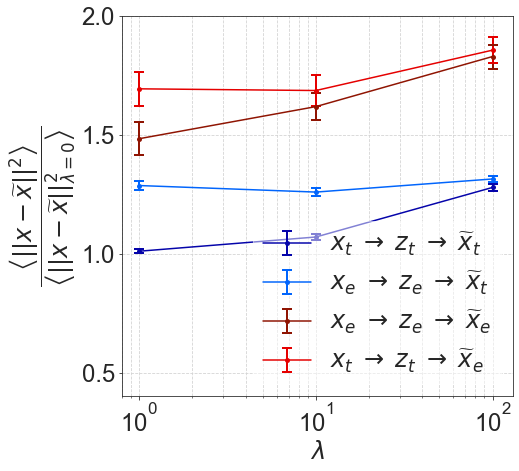

In [19]:
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')
cs = np.array([0+0.1,1.0,10.0,100.0])
ind = np.array([1,2,3]).astype(int)


ccT=['#0504aa','#0165fc']
ccE=['#8f1402','#e50000']

legend_txt_size = 24
ax_txt_size = 24

fig_4C = plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)

plt.sca(ax)

eprops={'fmt':'.-', 'ms': 10, 'mec': 'None',  'mew': 2,'elinewidth': 2, 'capsize': 5}

Ts = plt.errorbar(cs[ind],TfromT[ind]/TfromT[0],TfromT_err[ind],
            c=ccT[0],mfc=ccT[0],ecolor=ccT[0], **eprops,
            label=r'${x}_{t}$ $\rightarrow$ $z_{t}$ $\rightarrow$ $\widetilde{x}_{t}$')

Tc = plt.errorbar(cs[ind],TfromE[ind]/TfromT[0],TfromE_err[ind],
            c=ccT[1],mfc=ccT[1],ecolor=ccT[1], **eprops,
            label=r'${x}_{e}$ $\rightarrow$ $z_{e}$ $\rightarrow$ $\widetilde{x}_{t}$',)

Es = plt.errorbar(cs[ind],EfromE[ind]/EfromE[0],EfromE_err[ind],
            c=ccE[0],mfc=ccE[0],ecolor=ccE[0], **eprops,
            label=r'${x}_{e}$ $\rightarrow$ $z_{e}$ $\rightarrow$ $\widetilde{x}_{e}$')

Ec = plt.errorbar(cs[ind],EfromT[ind]/EfromE[0],EfromT_err[ind],
            c=ccE[1],mfc=ccE[1],ecolor=ccE[1], **eprops,
            label=r'${x}_{t}$ $\rightarrow$ $z_{t}$ $\rightarrow$ $\widetilde{x}_{e}$')

ax.set_xscale('log')
ax.set_xlim(0.8,130)
ax.set_ylim(0.4,2)
ax.set_yticks(np.arange(0.5,2.01,0.5))
plt.grid(True,which="both",ls="--",c='lightgray')

ax.set_xlabel('$\lambda$')
ax.set_ylabel(r'$\dfrac{\left\langle \left\|\|{x}-\widetilde{x} \right\|\|^2 \right\rangle}{\left\langle \left\|\|{x}-\widetilde{x} \right\|\|^2_{\lambda=0} \right\rangle}$')

plt.legend(handles = [Ts,Tc,Es,Ec],prop={'size': legend_txt_size},loc=4,frameon=True,edgecolor='white',facecolor='white', framealpha=0.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(ax_txt_size)
    
fig_4C.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig4C.pdf',
               dpi=300, format='pdf', bbox_inches='tight')

**Helper functions to plot data and reconstructions for individual cells**

In [10]:
import seaborn as sns

def plot_exp(true_gene_exp,pred_gene_exp,pred_gene_id,celltype,fileid):
    sns.set_style("ticks")
    true_col = '#0165fc'
    pred_col = '#e50000'
    
    fig_T = plt.figure(figsize=[8,4])
    plt.bar(np.arange(np.size(true_gene_exp)),np.ravel(true_gene_exp),tick_label=pred_gene_id,
            facecolor=true_col,ecolor=true_col,alpha=0.4,label='True')
    
    plt.bar(np.arange(np.size(pred_gene_exp)),np.ravel(pred_gene_exp),tick_label=pred_gene_id,
            facecolor=pred_col,ecolor=pred_col,alpha=0.4,label='Predicted')

    ax=plt.gca()
    for i,item in enumerate(ax.get_xticklabels()):
        item.set_rotation(90)
        item.set_fontsize(12)

    #ax.set_xlabel('Neuropeptide genes',labelpad=15)
    ax.set_xticks([])
    #ax.set_ylabel(r'Expression: $\log_{e}$[cpm+1]')
    ax.set_ylim(0,9)
    ax.set_yticks(np.arange(0,9,1))
    ax.yaxis.set_ticklabels(['0','','','','4','','','','8',''])
    ax.tick_params('both', length=5, which='major')
    ax.set_title(celltype,pad=30,verticalalignment='top')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]+ax.get_yticklabels()):
        item.set_fontsize(24)
    plt.tight_layout()
    return fig_T
    
def plot_features(true_E_features,pred_E_features,celltype,fileid):
    sns.set_style("ticks")
    true_col = '#0165fc'
    pred_col = '#e50000'
    
    fig_E = plt.figure(figsize=(8,4))
    plt.bar(np.arange(np.size(true_E_features)),np.ravel(true_E_features),
            facecolor=true_col,
            ecolor=true_col,alpha=0.4,label='True')
    
    plt.bar(np.arange(np.size(pred_E_features)),np.ravel(pred_E_features),
            facecolor=pred_col,
            ecolor=pred_col,alpha=0.4,label='Predicted')
    
    ax=plt.gca()
    for i,item in enumerate(ax.get_xticklabels()):
        item.set_rotation(90)
        item.set_fontsize(12)

    #ax.set_xlabel('sPCA Components')
    ax.set_ylim(-3,3)
    ax.set_xlim(-1,54)
    ax.set_yticks(np.arange(-3.1,3.1,0.5))
    ax.yaxis.set_ticklabels(['','','-2','','','','0','','','','2','',''])
    ax.set_xticks([])
    ax.tick_params('both', length=5, which='major')
    ax.set_title(celltype,pad=30,verticalalignment='top')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
    plt.tight_layout()
    return fig_E

**E $\rightarrow$ T**

 64%|██████▎   | 127/200 [00:01<00:00, 74.80it/s] 

2291


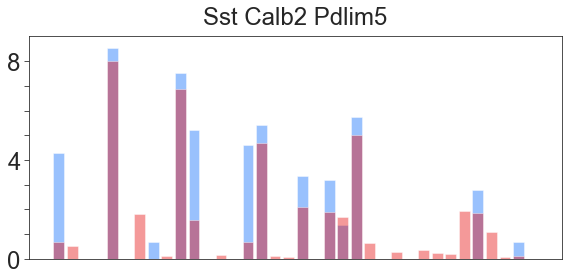

2543


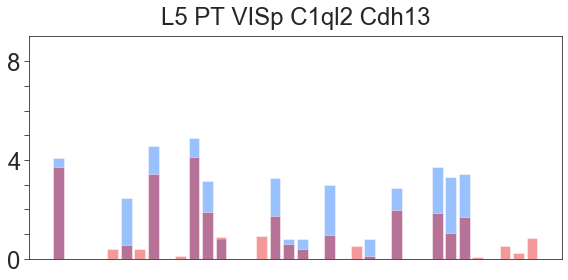

100%|██████████| 200/200 [00:02<00:00, 71.53it/s]


In [11]:
#Neuropeptides list:
gene_id_pep = np.array(['Vip', 'Npy', 'Sst', 'Penk', 'Tac2', 'Cck', 'Crh', 'Tac1', 'Pdyn', 'Cort', 'Pthlh', 'Pnoc',
                      'Adcyap1', 'Trh', 'Grp', 'Nmb', 'Nts', 'Rln1', 'Vipr1', 'Vipr2', 'Npy1r', 'Npy2r', 'Npy5r',
                      'Sstr1', 'Sstr2', 'Sstr3', 'Sstr4', 'Oprd1', 'Oprm1', 'Tacr3', 'Cckbr', 'Crhr1', 'Crhr2', 
                      'Tacr1', 'Oprk1', 'Pth1r', 'Oprl1', 'Adcyap1r1', 'Trhr', 'Trhr2', 'Grpr', 'Nmbr', 'Ntsr1',
                      'Ntsr2', 'Rxfp1', 'Rxfp2', 'Rxfp3'])

#Subset present among the 1252 genes used in the study:
pred_gene_id = gene_id_pep[np.isin(gene_id_pep,matfile['gene_id'])]

D = {}
ii=1
specific_cell_ids = [2291,2543]
for key in ['cs_10-0_']:
    for f,file in enumerate(tqdm(file_list)):
        if key in file:
            train_paired,val_paired,train_leaf,val_leaf = get_cvfold_crossmodal_recon(cvfile=cvsets_pth+file,refdata=matfile,full_data=True)
            gene_inds = np.isin(matfile['gene_id'],pred_gene_id)
            for i in range(np.size(val_leaf['labels'])):
                if val_leaf['T_ind'][i] in specific_cell_ids:

                    print(val_leaf['T_ind'][i])
                    celltype = val_leaf['labels'][i]
                    gene_exp = val_leaf['xT_from_zE'][i,:]
                    pred_gene_exp = gene_exp[gene_inds]

                    true_gene_exp = matfile['T_dat'][val_leaf['T_ind'][i],:]
                    true_gene_exp = true_gene_exp[gene_inds]

                    fig_4A = plot_exp(true_gene_exp,pred_gene_exp,pred_gene_id,celltype,val_leaf['T_ind'][i])
                    fig_4A.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig4A_'+str(i)+'.pdf',
                                   dpi=300, format='pdf', bbox_inches='tight')
                    ii=ii+1
                    plt.show()

**T $\rightarrow$ E**

100%|██████████| 200/200 [00:02<00:00, 83.51it/s] 


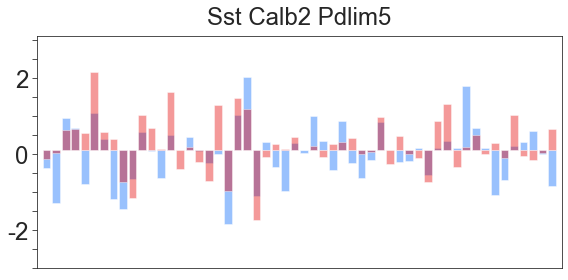

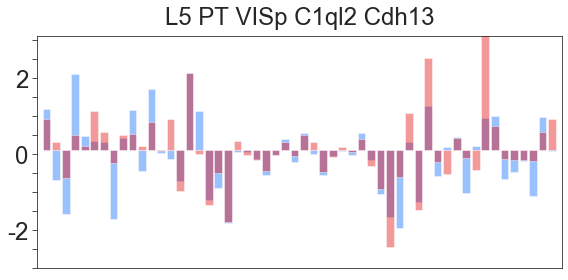

In [12]:
specific_cell_ids = [2291,2543]
D = {}                    
ii=1
for key in ['cs_10-0_']:
    for f,file in enumerate(tqdm(file_list)):
        if key in file:
            train_paired,val_paired,train_leaf,val_leaf = get_cvfold_crossmodal_recon(cvfile=cvsets_pth+file,refdata=matfile,full_data=True)
            for i in range(np.size(val_leaf['labels'])):
                if val_leaf['E_ind'][i] in specific_cell_ids:
                    celltype = val_leaf['labels'][i]
                    pred_E_features = val_leaf['xE_from_zT'][i,:]
                    true_E_features = matfile['E_dat'][val_leaf['E_ind'][i],:]
                    fig_4B = plot_features(true_E_features,pred_E_features,celltype,val_leaf['E_ind'][i])
                    fig_4B.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig4B_'+str(ii)+'.pdf',
                                   dpi=300, format='pdf', bbox_inches='tight')
                    ii=ii+1